# Exploratory data analysis

In [4]:
import pandas as pd
import numpy as np
from os.path import join
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

In [5]:
src = '../data'
dst = '../plots'
fname = 'V5_9_1 round coded_220216_clean.csv'
data = pd.read_csv(join(src, fname))

In [6]:
data['Action'] = data['Action'].apply(lambda x: eval(x) if x == x else np.nan)
data['Method'] = data['Method'].apply(lambda x: eval(x) if x == x else np.nan)
data['Discipline'] = data['Discipline'].apply(lambda x: eval(x) if x == x else np.nan)
data['Group'] = data['Group'].apply(lambda x: eval(x) if x == x else np.nan)
data['Geo'] = data['Geo'].apply(lambda x: eval(x) if x == x else np.nan)

## Wordcloud from article titles

In [7]:
text = ''
for title in data['Article Title']:
    text += ' '
    text += title
    
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white", colormap=plt.get_cmap('inferno'))
wordcloud = wc.generate(text)

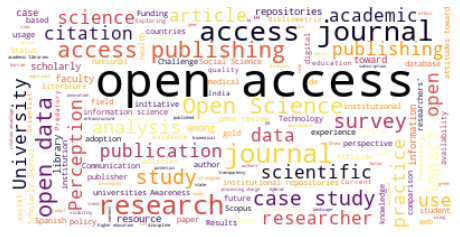

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis('off')
plt.savefig(join(dst, 'title_text_wordcloud.png'), dpi=300)

## Citations over publication year

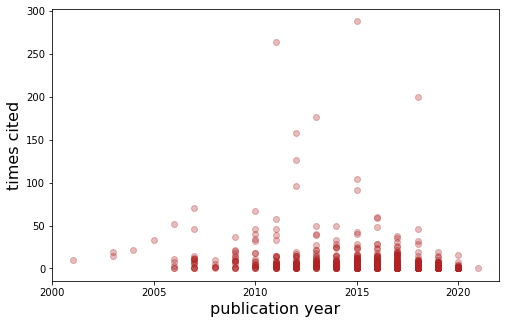

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
cols = ['Publication Year', 'Times Cited, All Databases']
tmp = data[cols].dropna(subset=cols).copy()
tmp = tmp.astype(int)
ax.scatter(tmp['Publication Year'], tmp['Times Cited, All Databases'],
           color='FireBrick', alpha=0.3)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('times cited', fontsize=16)
ax.set_xlabel('publication year', fontsize=16)
plt.savefig(join(dst, 'times_cited_over_publication_year.pdf'))

## Actions over years

In [10]:
disambiguated_action = pd.DataFrame()
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Action'] != row['Action']: # NaN check
        continue
    if len(row['Action']) == 1:
        disambiguated_action = disambiguated_action.append(
            {'Action':row['Action'][0],
             'year':int(row['Publication Year']),
             #'N':
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Action']) > 1:
        for action in row['Action']:
            disambiguated_action = disambiguated_action.append(
                {'Action':action,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        print('found one!')

In [11]:
actions = disambiguated_action\
    .groupby(by=['Action', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for action in disambiguated_action['Action'].unique():
    for year in range(2001, 2022):
        if not actions.index.isin([(action, year)]).any():
            actions.loc[(action, year), :] = 0
            
actions = actions.reset_index()
actions['year'] = actions['year'].astype(int)
actions = actions.sort_values(by=['Action', 'year'], ascending=True)

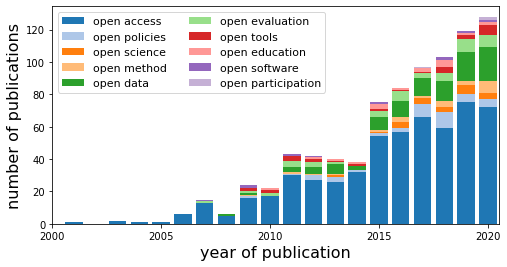

In [12]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, action in enumerate(disambiguated_action['Action'].unique()):
    tmp = actions[actions['Action'] == action]
    label = 'open {}'.format(action.split('open')[1])
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'actions_over_years.pdf'))

## Methods over years

In [13]:
disambiguated_method = pd.DataFrame()
no_method = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Method'] != row['Method']: # NaN check
        continue
    if len(row['Method']) == 1:
        disambiguated_method = disambiguated_method.append(
            {'Method':row['Method'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Method']) > 1:
        for method in row['Method']:
            disambiguated_method = disambiguated_method.append(
                {'Method':method,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_method = disambiguated_method.append(
            {'Method':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_method += 1
print('{} entries without specified method'.format(no_method))

0 entries without specified method


In [14]:
methods = disambiguated_method\
    .groupby(by=['Method', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for method in disambiguated_method['Method'].unique():
    for year in range(2001, 2022):
        if not methods.index.isin([(method, year)]).any():
            methods.loc[(method, year), :] = 0
            
methods = methods.reset_index()
methods['year'] = methods['year'].astype(int)
methods = methods.sort_values(by=['Method', 'year'], ascending=True)

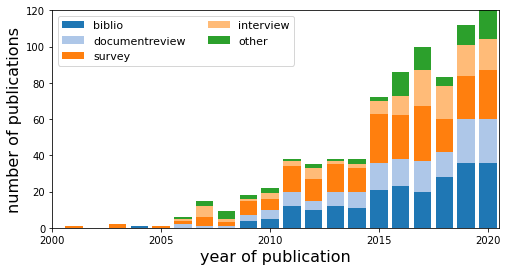

In [15]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, method in enumerate(disambiguated_method['Method'].unique()):
    tmp = methods[methods['Method'] == method]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=method,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'methods_over_years.pdf'))

## Disciplines over years

In [16]:
disambiguated_discipline = pd.DataFrame()
no_discipline = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Discipline'] != row['Discipline']: # NaN check
        continue
    if len(row['Discipline']) == 1:
        disambiguated_discipline = disambiguated_discipline.append(
            {'Discipline':row['Discipline'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Discipline']) > 1:
        for discipline in row['Discipline']:
            disambiguated_discipline = disambiguated_discipline.append(
                {'Discipline':discipline,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_discipline = disambiguated_discipline.append(
            {'Discipline':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_discipline += 1
print('{} entries without specified discipline'.format(no_discipline))

0 entries without specified discipline


In [17]:
disciplines = disambiguated_discipline\
    .groupby(by=['Discipline', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for discipline in disambiguated_discipline['Discipline'].unique():
    for year in range(2001, 2022):
        if not disciplines.index.isin([(discipline, year)]).any():
            disciplines.loc[(discipline, year), :] = 0
            
disciplines = disciplines.reset_index()
disciplines['year'] = disciplines['year'].astype(int)
disciplines = disciplines.sort_values(by=['Discipline', 'year'], ascending=True)

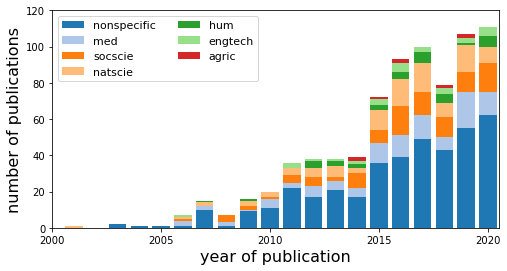

In [18]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['Discipline'].unique()):
    tmp = disciplines[disciplines['Discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'disciplines_over_years.pdf'));

## Groups over years

In [19]:
disambiguated_group = pd.DataFrame()
no_group = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Group'] != row['Group']: # NaN check
        continue
    if len(row['Group']) == 1:
        disambiguated_group = disambiguated_group.append(
            {'Group':row['Group'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Group']) > 1:
        for group in row['Group']:
            disambiguated_group = disambiguated_group.append(
                {'Group':group,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_group = disambiguated_group.append(
            {'Group':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_group += 1
print('{} entries without specified group'.format(no_group))

0 entries without specified group


In [20]:
groups = disambiguated_group\
    .groupby(by=['Group', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for group in disambiguated_group['Group'].unique():
    for year in range(2001, 2022):
        if not groups.index.isin([(group, year)]).any():
            groups.loc[(group, year), :] = 0
            
groups = groups.reset_index()
groups['year'] = groups['year'].astype(int)
groups = groups.sort_values(by=['Group', 'year'], ascending=True)

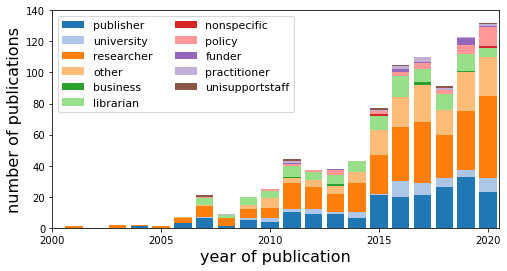

In [21]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['Group'].unique()):
    tmp = groups[groups['Group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
plt.savefig(join(dst, 'groups_over_years.pdf'));

## Geo over years

In [22]:
disambiguated_geo = pd.DataFrame()
no_geo = 0
for i, row in data.dropna(subset=['Publication Year']).iterrows():
    if row['Geo'] != row['Geo']: # NaN check
        continue
    if len(row['Geo']) == 1:
        disambiguated_geo = disambiguated_geo.append(
            {'Geo':row['Geo'][0],
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
    elif len(row['Geo']) > 1:
        for geo in row['Geo']:
            disambiguated_geo = disambiguated_geo.append(
                {'Geo':geo,
                 'year':int(row['Publication Year']),
                 'ID':row['ID']}, ignore_index=True)
    else:
        disambiguated_geo = disambiguated_geo.append(
            {'Geo':'not specified',
             'year':int(row['Publication Year']),
             'ID':row['ID']}, ignore_index=True)
        no_geo += 1
print('{} entries without specified geo'.format(no_geo))

1 entries without specified geo


In [23]:
geos = disambiguated_geo\
    .groupby(by=['Geo', 'year'])\
    .agg('count')\
    .rename(columns={'ID':'count'})\

for geo in disambiguated_geo['Geo'].unique():
    for year in range(2001, 2022):
        if not geos.index.isin([(geo, year)]).any():
            geos.loc[(geo, year), :] = 0
            
geos = geos.reset_index()
geos['year'] = geos['year'].astype(int)
geos = geos.sort_values(by=['Geo', 'year'], ascending=True)

In [24]:
disambiguated_geo['Geo'].value_counts()[0:15]

nonspecific    279
USA             78
GBR             48
ESP             37
DEU             36
IND             34
CAN             25
FRA             22
CHN             22
ITA             21
AUS             18
NGA             16
KOR             14
AUT             14
EU              13
Name: Geo, dtype: int64

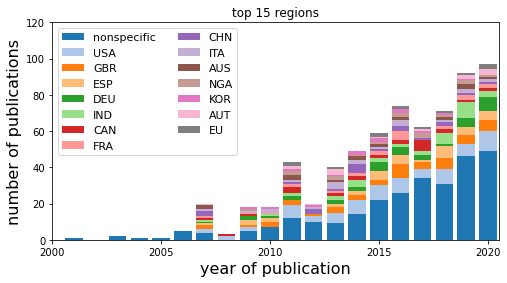

In [25]:
cmap = plt.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8, 4))
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['Geo'].value_counts()[0:15].index):
    tmp = geos[geos['Geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=11)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 120)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=16)
ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('top 15 regions')
plt.savefig(join(dst, 'geos_over_years.pdf'));

## Compilation plot

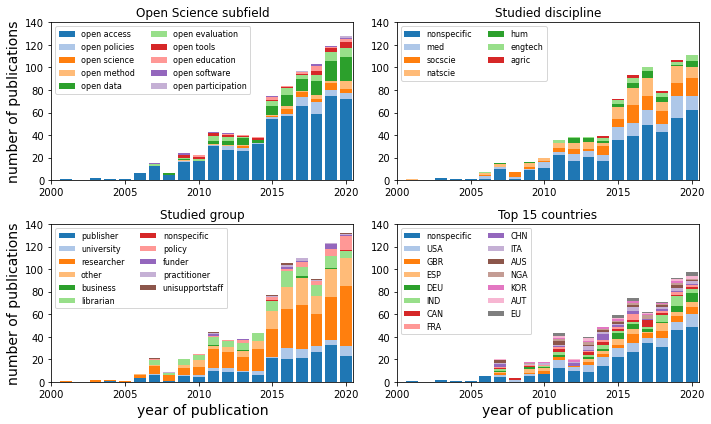

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
ax = axes[0, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, action in enumerate(disambiguated_action['Action'].unique()):
    tmp = actions[actions['Action'] == action]
    label = 'open {}'.format(action.split('open')[1])
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=label,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Open Science subfield')

ax = axes[0, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, discipline in enumerate(disambiguated_discipline['Discipline'].unique()):
    tmp = disciplines[disciplines['Discipline'] == discipline]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=discipline,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=16)
#ax.set_xlabel('year of publication', fontsize=16)
ax.set_title('Studied discipline')

ax = axes[1, 0]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, group in enumerate(disambiguated_group['Group'].unique()):
    tmp = groups[groups['Group'] == group]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=group,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Studied group')

ax = axes[1, 1]
bottom = np.zeros(len(data['Publication Year'].unique()))
for i, geo in enumerate(disambiguated_geo['Geo'].value_counts()[0:15].index):
    tmp = geos[geos['Geo'] == geo]
    ax.bar(tmp['year'], tmp['count'], bottom=bottom, label=geo,
           color=cmap(i))
    bottom += tmp['count'].values
    
ax.legend(ncol=2, fontsize=8, loc=2)
ax.set_xlim(2000, 2020.5)
ax.set_ylim(0, 140)
ax.set_xticks(range(2000, 2021, 5))
#ax.set_ylabel('number of publications', fontsize=14)
ax.set_xlabel('year of publication', fontsize=14)
ax.set_title('Top 15 countries')

fig.tight_layout()
plt.savefig(join(dst, 'categories.png'), dpi=300)